In [1]:
import numpy as np
import numpy.ma as ma

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import ticker

from scipy import signal, spatial
from scipy.spatial.distance import pdist,cdist, squareform
from sklearn.feature_extraction import image
import itertools
import random
from scipy import signal

# After installing new version of numpy we have warnings.
# If you want to remove them simply uncomment these 2 lines.
from warnings import simplefilter
simplefilter(action='ignore', category=DeprecationWarning)

Manifold learning, local dimension and stability for the sea surface temperature anomaly (SSTa) only field.

- The SSTa field comes from a 300 years long piControl integration of the GFDL-CM4 model. 

- Temporal resolution: 14 days

- Spatial resolution: 1/4 degree (here bilinearly remapped to 2 by 2 degrees)

Local dimension and stability for daily suface temperature (i.e., temperaturee at 2 meters) in the tropical Pacific. Main code for computation of the metrics has been downloaded from Yoann Robin repository https://github.com/yrobink/CDSK/tree/master/python/CDSK . Thanks Yoann!

Here we show the main ideas using 1 variables. To add more variables it is enough to concatenate all variables considered at each time t.

## Some functions

In [2]:
import netCDF4
from netCDF4 import Dataset
def importNetcdf(path,variable_name):
    nc_fid = Dataset(path, 'r')
    field = nc_fid.variables[variable_name][:]     
    return field 

def masked_array_to_numpy(data):
    return np.ma.filled(data.astype(np.float32), np.nan);

# Loading the data

In [3]:
# Load data
path = './data/tos_300yrs_Pacific_tropics_a_biweekly_2deg.nc'

# Latitude
lat = importNetcdf(path,'lat')
lat = masked_array_to_numpy(lat)

# Longitude
lon = importNetcdf(path,'lon')
lon = masked_array_to_numpy(lon)

# Transform latitudes in radians
latitudes = np.radians(lat);
# Assign a weight to each latitude phi
lat_weights = np.cos(latitudes).reshape(len(latitudes),1)

# Temperature field
data = importNetcdf(path,'tos')
data = masked_array_to_numpy(data)

# Land mask
land = data[0]
land[~np.isnan(land)]=0

In [4]:
############################ Temperature

# Weight with cosine of latitude
data = data * lat_weights

# Standardize it to zero mean and unit variance is important when using more than 1 variable
# This is not the case here but it does not hurt doing it

# Remove mean from each time series
data = data - np.nanmean(data)

# Standardize 
data = data/np.nanstd(data)

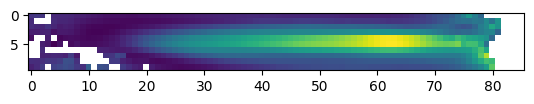

In [5]:
# Let's check the standard deviation

# OK we see ENSO
plt.imshow(np.flipud(np.std(data,axis = 0)))

# Embed data

In [8]:
np.shape(data)

(7848, 10, 86)

In [9]:
# Dimensions of each field
dim_lon = np.shape(data)[2] # Points in Y axis
dim_lat = np.shape(data)[1] # Points in X axis
dim_t = np.shape(data)[0]

data_reshaped = data.reshape(dim_t,dim_lat*dim_lon)
np.shape(data_reshaped)

(7848, 860)

So, from a 10 by 86 field we go to a 860 dimensional system

In [10]:
# Consider only data that are not nans

data_embed = []

for i in range(np.shape(data_reshaped)[1]):
    if ~np.isnan(data_reshaped[0,i]):
       data_embed.append(data_reshaped[:,i])
data_embed = np.transpose(np.array(data_embed))

In [11]:
# we have 7848 bi-weeks in a 771th dimensional state space

np.shape(data_embed)

(7848, 771)

# Dynamical systems metrics

In [12]:
from metrics import *

In [13]:
print('Computing local dimension and theta')
X = data_embed
localDim,theta = indicators( X , Y = None , metric = "euclidean" , q = 0.97 , n_jobs = 1 , pareto_fit = "scipy" , theta_fit = "sueveges" , distXY = None )

Computing local dimension and theta


/Users/fabrizio/Dropbox/Science_and_Co/CODES_and_Ideas/Dim_reduction/state_space/example/metrics.py:105: RuntimeWarning: overflow encountered in cast
  distXY[distXY == 0] = sys.float_info.max


In [14]:
# Save the results
np.save('./results/local_dimension.npy',localDim)
np.save('./results/theta.npy',theta)

# Manifold learning

In [15]:
import manifold_learning

## PCA

In [36]:
X = data_embed
n_components = 50

projected_embedding_PCA, variance_explained_PCA, resid_variance_PCA = manifold_learning.pca_manifold_learning(X, n_components)

In [37]:
projected_embedding_PCA.shape

(7848, 50)

In [38]:
# Save the results
np.save('./results/projected_embedding_PCA.npy',projected_embedding_PCA)
np.save('./results/variance_explained_PCA.npy',variance_explained_PCA)
np.save('./results/resid_variance_PCA.npy',resid_variance_PCA)

## Isomap

In [45]:
X = data_embed
k = 10 # Assumption: the (curved) manifold is flat in a k-neighborhood with k = 10
n_components = 50

projected_embedding_isomap, resid_variance_isomap = manifold_learning.isomap_manifold_learning(X,k,n_components)

In [40]:
projected_embedding_isomap.shape

(7848, 50)

In [46]:
# Save the results
np.save('./results/projected_embedding_isomap.npy',projected_embedding_isomap)
np.save('./results/resid_variance_isomap.npy',resid_variance_isomap)

## Compare residual variance

In [51]:
projected_embedding_PCA = np.load('./results/projected_embedding_isomap.npy')
projected_embedding_isomap = np.load('./results/projected_embedding_isomap.npy')

resid_variance_PCA = np.load('./results/resid_variance_PCA.npy')
resid_variance_isomap = np.load('./results/resid_variance_isomap.npy')

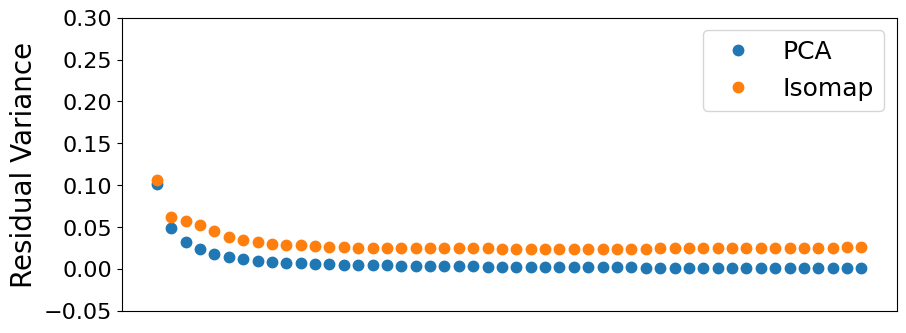

In [53]:
fig = plt.figure(figsize=(10,8))

# Start plotting the reference field and 1 anomaly
point_size = 15
n_components = len(resid_variance_PCA)

ax = fig.add_subplot(211)

ax.plot(np.arange(1,n_components+1,1),resid_variance_PCA,".",markersize = point_size,label="PCA")
ax.plot(np.arange(1,n_components+1,1),resid_variance_isomap,".", markersize = point_size,label="Isomap")
plt.legend(loc="upper right",fontsize = 18)
#plt.xlabel('Component',fontsize = 20)
plt.ylabel('Residual Variance',fontsize = 20)
plt.ylim(-0.05,0.3)
#ax.text(3, 0.8, 'ERA5', fontsize=18)
#plt.xticks(np.arange(1,21,2),fontsize = 16)
plt.xticks([])
plt.yticks(fontsize = 16)

plt.subplots_adjust(wspace=0, hspace=0.1)

plt.show()
#fig.savefig('./figures/residual_variance.png',bbox_inches='tight') 

## Scatter plot of local dimension, theta and first Isomap

In [32]:
t_a.shape

(7848, 10)

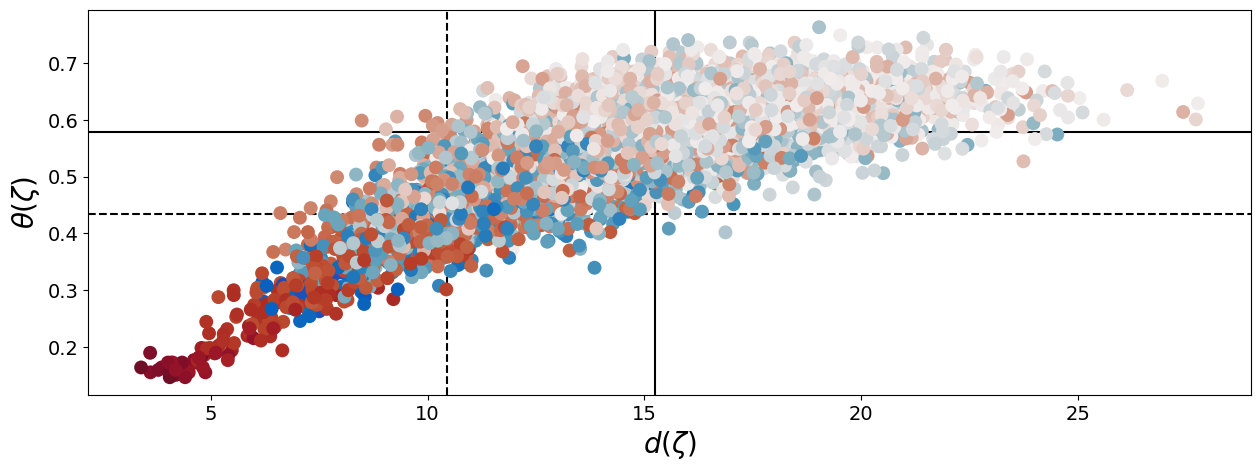

In [54]:
import cmocean

fig = plt.figure(figsize=(15,5))

# I need this for the colorbars

point_size = 100

ax = fig.add_subplot(111)

#cmap = mpl.cm.get_cmap('seismic')
cmap = cmocean.cm.balance

t_a = projected_embedding_isomap[:,0]/np.std(projected_embedding_isomap[:,0])

#cmap = mpl.cm.get_cmap('Spectral_r')

plt.axvline(x=np.percentile( localDim , 100 * 0.1),c = 'k',ls = '--',alpha=1,zorder = 0)
plt.axhline(y=np.percentile( theta , 100 * 0.1),c = 'k',ls = '--',alpha=1,zorder = 0)
plt.axvline(x=np.percentile( localDim , 100 * 0.5),c = 'k',ls = '-',alpha=1,zorder = 0)
plt.axhline(y=np.percentile( theta , 100 * 0.5),c = 'k',ls = '-',alpha=1,zorder = 0)

plt.scatter(localDim, theta,c=t_a,cmap=cmap,marker = 'o',s = point_size,linewidths=0,vmin=-4,vmax=4)
#plt.scatter(localDim, theta,cmap=cmap,marker = 'o',s = point_size,linewidths=0,vmin=-4,vmax=4)

plt.xlabel('$d(\zeta)$',fontsize = 20)
plt.ylabel(r'${\theta(\zeta)}$',fontsize = 20)
#plt.xlim(10,80)
#plt.ylim(0.1,0.7)
plt.tick_params(labelsize=14)
plt.subplots_adjust(wspace=0.05, hspace=0.15)

#fig.savefig('./../../figures/final_plots/figures/theta_vs_d.png',bbox_inches='tight') 